<a href="https://colab.research.google.com/github/google/neural-tangents/blob/main/notebooks/neural_tangents_cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Utils

In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents

In [1]:
import jax.numpy as np

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

In [2]:
import matplotlib, matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

In [3]:
def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-np.pi, np.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

In [4]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = np.reshape(mean, mean.shape[:1] + (-1,))
  var = np.diagonal(cov, axis1=1, axis2=2)
  ys = np.reshape(ys, (1, -1))

  mean_predictions = 0.5 * np.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

# Neural Tangents Cookbook

In this notebook we explore the training of infinitely-wide, Bayesian, neural networks using a library called [Neural Tangents](https://github.com/google/neural-tangents). Recent work has shown that such networks are Gaussian Processes with a particular compositional kernel called the NNGP kernel. More recently, it was shown that predictions resulting from these networks following Gradient Descent are Gaussian with a distribution that can be computed in closed form using the [Neural Tangent Kernel](). Neural Tangents provides a high level library to compute NNGP and NT kernels for a wide range of neural networks. See [the paper]() for a more detailed description of the library itself.

Our goal will be to train an ensemble of neural networks on a simple synthetic task. We'll then compare the results of this ensemble with the prediction of the NTK theory. Finally, we'll play around with different neural network architectures to see how this affects the resulting kernel.

## Creating a Dataset

We're going to build a widely used synthetic dataset that's used extensively in [Pattern Recognition and Machine Learning](). Incidentally, Pattern Recognition and Machine Learning is an outstanding book by Christopher Bishop that was recently released for free.

Our training data is going to be drawn from a process,
    $$y = f(x) + \epsilon$$
where $f(x)$ is a deterministic function and $\epsilon\sim\mathcal N(0, \sigma)$ is Gaussian noise with some scale. We're going to choose $f(x) = \sin(x)$ with $x\sim\text{Uniform}(-\pi, \pi)$. Our testing data will be $y = f(x)$ for $x$ linearly spaced in $[-\pi, \pi]$. Feel free to try out different functions and domains!

In [5]:
# Random state
key = random.PRNGKey(10)

In [6]:
# Constants to define dataset
train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: np.sin(x)

In [7]:
# Generate random training data
key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-np.pi, maxval=np.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

In [8]:
# Generate random test data with shape (m, 1), since we treat this as a model with one feature
# The x's are linearly spaced
test_xs = np.linspace(-np.pi, np.pi, test_points)
test_xs = np.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

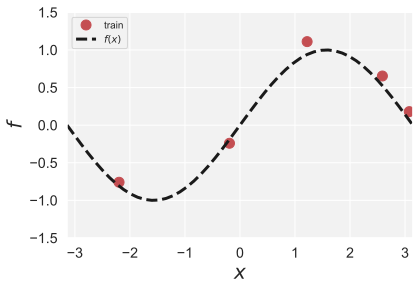

In [9]:
# Plot data
plot_fn(train, test)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

## Defining a Neural Network

In [10]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

# Using JAX feature to compile functions so that they are executed as single calls to the GPU
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

In [11]:
# Take several draws of the parameters of the network
prior_draws = []
for _ in range(10):
  key, net_key = random.split(key)
  _, params = init_fn(net_key, (-1, 1))
  prior_draws += [apply_fn(params, test_xs)]

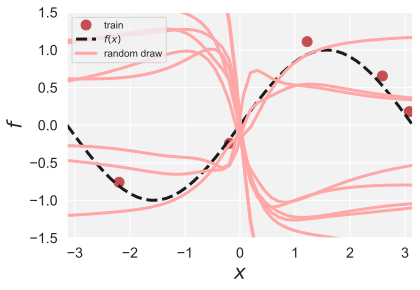

In [12]:
# Plot network functions
plot_fn(train, test)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((0.85, 0.6))

Next we can look at the exact prior over functions in the infinite-width limit using the `kernel_fn`. The kernel function has the signature `kernel = kernel_fn(x_1, x_2)` which computes the kernel between two sets of inputs `x_1` and `x_2`. The `kernel_fn` can compute two different kernels: the NNGP kernel which describes the Bayesian infinite network and the NT kernel which describes how this network evolves under gradient descent. We would like to visualize the standard deviation of the infinite-width function distribution at each $x$. This is given by the diagonal of the NNGP kernel. We compute this now and then plot it compared with the draws above.

In [13]:
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = np.sqrt(np.diag(kernel))

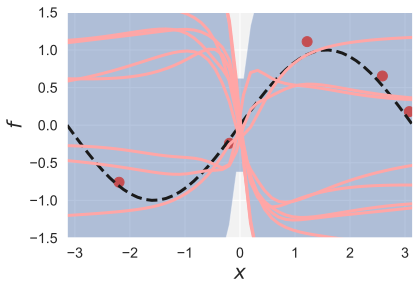

In [14]:
plot_fn(train, test)

plt.fill_between(
    np.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for p in prior_draws:
  plt.plot(test_xs, p, linewidth=3, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

## Infinite Width Inference

We can use the infinite-width GP defined above to perform exact Bayesian inference using the infinite width network. To do this, we will use the function `neural_tangents.predict.gradient_descent_mse_ensemble` that performs this inference exactly. `predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs, train_ys); mean, cov = predict_fn(x_test=test_xs, get='ntk', compute_cov=True)` computes the mean and covariance of the network evaluated on the test points after training. This `predict_fn` function includes two different modes: in "NNGP" mode we compute the Bayesian posterior (which is equivalent to gradient descent with all but the last-layer weights frozen), in "NTK" mode we compute the distribution of networks after gradient descent training.

We want to do exact Bayesian inference so we'll start off using the "NNGP" setting. We will compute and plot these predictions now; we will be concerned with the standard deviation of the predictions on test points which will be given by the diagonal of the covariance matrix.

In [ ]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs,
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp',
                                        compute_cov=True)

nngp_mean = np.reshape(nngp_mean, (-1,))
nngp_std = np.sqrt(np.diag(nngp_covariance))

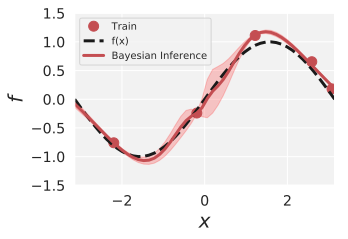

In [ ]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))

We see that our posterior exactly fits all of the training points as expected. We also see that the there is significant uncertainty in the predictions between the points in the middle.

Next, we would like to compute the result of doing gradient descent on our infinite network for an *infinite* amount of time. To do this, we will use the "NTK" inference mode. Note that otherwise the call to `predict_fn` looks identical. We will compare the result of true Bayesian inference with gradient descent.

In [ ]:
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk',
                                      compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_covariance))

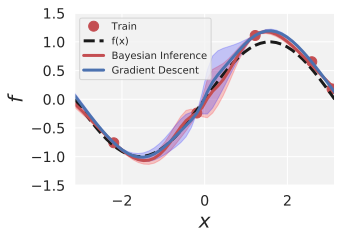

In [ ]:
plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

We see that while the result of gradient descent and bayesian inference are similar, they are not identical.

Not only can we do inference at infinite times, but we can also perform finite-time inference. We will use this to predict the mean of the train and test losses over the course of training. To compute the mean MSE loss, we need to access the mean and variance of our networks predictions as a function of time. To do this, we call our `predict_fn` function with finite times `t` (as opposed to using the default value `t=None` earlier, considered as infinite time). Note that `predict` can act on both scalar and array values, so we simply invoke the function.

In [ ]:
ts = np.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

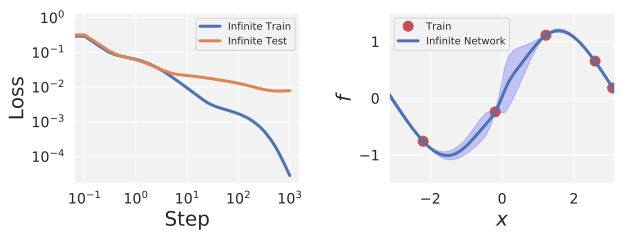

In [ ]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))

## Training a Neural Network

We will now compare the results of gradient descent GP-inference computed above to the result of training an ensemble of finite width neural networks. We first train a single network drawn from the prior and then we will show how to generalize this to an ensemble. To do this we use JAX's gradient descent [optimizer](https://github.com/google/jax#first-order-optimization). Optimizers are described by a triple of functions `(init_fn, update_fn, get_params)`. Here, `init_fn(params)` takes an initial set of parameters and returns an optimizer state that can include extra information (like the velocity in the `momentum` optimizer). `opt_update(step, grads, state)` takes a new state and updates it using gradients. Finally, `get_params(state)` returns the parameters for a given state.

In [ ]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

Next we need to define a loss and a gradient of the loss. We'll use an MSE loss. The function `grad` is another [JAX function](https://github.com/google/jax#automatic-differentiation-with-grad) that takes a function and returns a new function that computes its gradient.

In [ ]:
loss = jit(lambda params, x, y: 0.5 * np.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

Now we want to actually train the network. To do this we just initialize the optimizer state and then update it however many times we want. We'll record the train and test loss after each step.


In [ ]:
train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
  opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses += [loss(get_params(opt_state), *train)]
  test_losses += [loss(get_params(opt_state), *test)]

Finally, lets plot the loss over the course of training and the function after training compared with our GP inference.

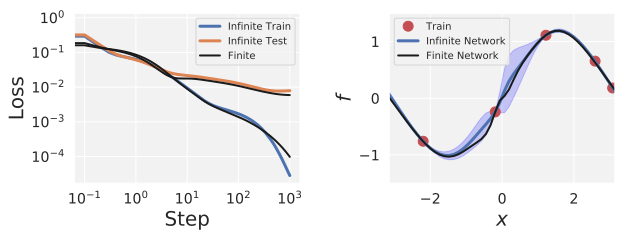

In [ ]:
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(get_params(opt_state), test_xs), 'k-', linewidth=2)

legend(
    ['Train', 'Infinite Network', 'Finite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))

## Training an Ensemble of Neural Networks

The draw above certainly seems consistent with exact inference. However, as discussed above to make a more quantitative comparison we want to train an ensemble of finite-width networks. We could use a for-loop to loop over all the different instantiations that we wanted to evaluate. However, it is more convenient and efficient to use another [JAX feature](https://github.com/google/jax#auto-vectorization-with-vmap) called `vmap`. `vmap` takes a function and vectorizes it over a batch dimension. In this case, we're going to add a batch dimension to our training loop so that we train a whole batch of neural networks at once. To do that, let's first wrap our whole training loop in a function. The function will take a random state and train a network based on that random state.

In [ ]:
def train_network(key):
  train_losses = []
  test_losses = []

  _, params = init_fn(key, (-1, 1))
  opt_state = opt_init(params)

  for i in range(training_steps):
    train_losses += [np.reshape(loss(get_params(opt_state), *train), (1,))]
    test_losses += [np.reshape(loss(get_params(opt_state), *test), (1,))]
    opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses = np.concatenate(train_losses)
  test_losses = np.concatenate(test_losses)
  return get_params(opt_state), train_losses, test_losses

We can test it to make sure that we get a trained network.

In [ ]:
# test {"skip": true}
params, train_loss, test_loss = train_network(key)

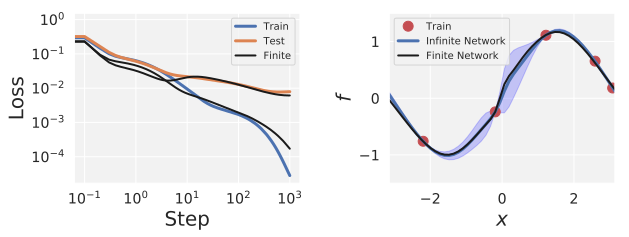

In [ ]:
# test {"skip": true}
plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_loss, 'k-', linewidth=2)
plt.loglog(ts, test_loss, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Train', 'Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(params, test_xs), 'k-', linewidth=2)

legend(['Train', 'Infinite Network', 'Finite Network'], loc='upper left')

finalize_plot((1.5, 0.6))

Now, to train an ensemble we just have to apply `vmap` to `train_network`. The resulting function will take a vector of random states and will train one network for each random state in the vector.

In [ ]:
# test {"skip": true}
ensemble_size = 100
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key)

Let's plot the empirical standard deviation in the loss over the course of training as well as well as for the function after gradient descent compared with the exact inference above.

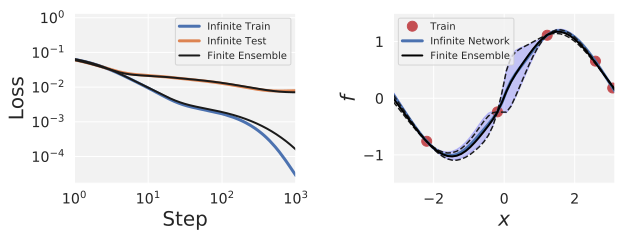

In [ ]:
# test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))

We see pretty nice agreement between exact inference of the infinite-width networks and the result of training an ensemble! Note that we do see some deviations in the training loss at the end of training. This is ameliorated by using a wider network.

## Playing Around with the Architecture

To demonstrate the ease of specifying more exotic architecture, can try to reproduce the above results with different choices of architecture. For fn, let's see what happens if we add residual connections.

In [ ]:
ResBlock = stax.serial(
    stax.FanOut(2),
    stax.parallel(
        stax.serial(
            stax.Erf(),
            stax.Dense(512, W_std=1.1, b_std=0),
        ),
        stax.Identity()
    ),
    stax.FanInSum()
)

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1, b_std=0),
    ResBlock, ResBlock, stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

Given this new architecture, let's train a new ensemble of models.

In [ ]:
# test {"skip": true}
ensemble_size = 100
learning_rate = 0.1
ts = np.arange(0, 10 ** 3, learning_rate)

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

key, = random.split(key, 1)
ensemble_key = random.split(key, ensemble_size)
params, train_loss, test_loss = vmap(train_network)(ensemble_key)

Finally, let's repeat our NTK-GP inference

In [ ]:
# test {"skip": true}
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs,
                                                      train_ys, diag_reg=1e-4)
ntk_mean, ntk_var = predict_fn(x_test=test_xs, get='ntk', compute_cov=True)

ntk_mean = np.reshape(ntk_mean, (-1,))
ntk_std = np.sqrt(np.diag(ntk_var))

ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

Now let's draw the result!

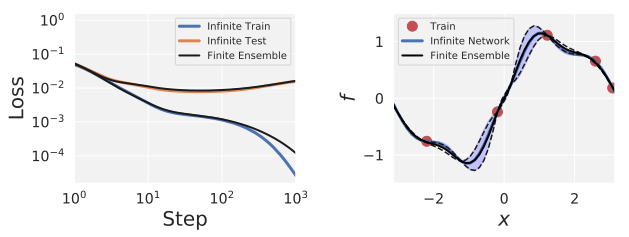

In [ ]:
# test {"skip": true}
plt.subplot(1, 2, 1)

mean_train_loss = np.mean(train_loss, axis=0)
mean_test_loss = np.mean(test_loss, axis=0)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, mean_train_loss, 'k-', linewidth=2)
plt.loglog(ts, mean_test_loss, 'k-', linewidth=2)

plt.xlim([10 ** 0, 10 ** 3])

plt.xscale('log')
plt.yscale('log')
format_plot('Step', 'Loss')

legend(['Infinite Train', 'Infinite Test', 'Finite Ensemble'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    np.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

ensemble_fx = vmap(apply_fn, (0, None))(params, test_xs)

mean_fx = np.reshape(np.mean(ensemble_fx, axis=0), (-1,))
std_fx = np.reshape(np.std(ensemble_fx, axis=0), (-1,))

plt.plot(test_xs, mean_fx - 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx + 2 * std_fx, 'k--', label='_nolegend_')
plt.plot(test_xs, mean_fx, linewidth=2, color='black')

legend(['Train', 'Infinite Network', 'Finite Ensemble'], loc='upper left')

plt.xlim([-np.pi, np.pi])
plt.ylim([-1.5, 1.5])

format_plot('$x$', '$f$')
finalize_plot((1.5, 0.6))
